In [2]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libabries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check version of Pytorch
print(torch. __version__)

1.10.0


In [6]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
train_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/train"
test_dir = "../../../DataSet/Transformed - DMR - Database For Mastology Research - Visual Lab/test"

In [8]:
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
num_features = model_resnet18.fc.in_features 
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [10]:
# Add a fully-connected layer for classification
model_resnet18.fc = nn.Linear(num_features, 2)
model_resnet18 = model_resnet18.to(device)

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.0001, momentum=0.9)

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [13]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [12]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_resnet18.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model_resnet18.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.0467 Acc: 74.9911% Time: 977.5202s
[Test #1] Loss: 0.0462 Acc: 75.4622% Time: 1094.7000s
Epoch 1 running
[Train #2] Loss: 0.0425 Acc: 76.4161% Time: 1792.1811s
[Test #2] Loss: 0.0410 Acc: 75.8824% Time: 1898.5612s
Epoch 2 running
[Train #3] Loss: 0.0399 Acc: 76.9505% Time: 2613.1351s
[Test #3] Loss: 0.0365 Acc: 77.2269% Time: 2722.5305s
Epoch 3 running
[Train #4] Loss: 0.0379 Acc: 79.6580% Time: 3451.4997s
[Test #4] Loss: 0.0328 Acc: 83.7815% Time: 3561.9982s
Epoch 4 running
[Train #5] Loss: 0.0343 Acc: 81.9024% Time: 4296.5996s
[Test #5] Loss: 0.0294 Acc: 84.7059% Time: 4409.7101s
Epoch 5 running
[Train #6] Loss: 0.0327 Acc: 82.7218% Time: 5160.5843s
[Test #6] Loss: 0.0268 Acc: 85.0420% Time: 5275.6342s
Epoch 6 running
[Train #7] Loss: 0.0301 Acc: 84.0755% Time: 6019.7136s
[Test #7] Loss: 0.0243 Acc: 88.0672% Time: 6132.1945s
Epoch 7 running
[Train #8] Loss: 0.0299 Acc: 84.2893% Time: 6878.7583s
[Test #8] Loss: 0.0217 Acc: 88.7395% Time: 6991.6619s
E

In [13]:
save_path = 'models/breast_thermo_cancer-classifier_resnet_18_final.pth'
torch.save(model_resnet18.state_dict(), save_path) #model_resnet18

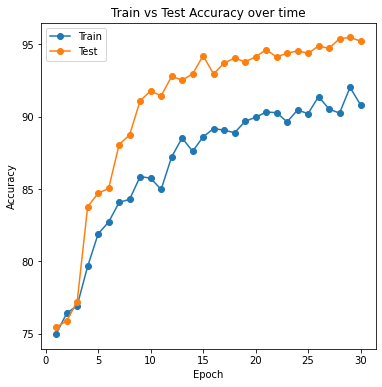

In [14]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()

In [15]:
# Get data to check on the performance of each label
y_pred = []
y_true = []

#model_resnet18.load_state_dict(torch.load('models/breast_thermo_cancer-classifier_resnet_18_final.pth'))

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    model_resnet18.eval()
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18(inputs) # Feed Network
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

In [ ]:
# Visualization and result
# constant for classes
classes = test_dataset.classes
# Build confusion matrix
print("Accuracy on Training set: ",accuracy_score(y_true, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
print('Classification report: \n', classification_report(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (7,7))
plt.title("Confusion matrix for Breast Cancer classification ")
sn.heatmap(df_cm, annot=True)